In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import altair as alt

# Data Loading and Cleaning

## Data Loading

In [2]:
# Load dataset
train = pd.read_csv('/Users/emmali/Downloads/train_data.csv')
predict = pd.read_csv('/Users/emmali/Downloads/test_data.csv')

In [3]:
# Make copy so do not hamper the original datasets
train_original = train.copy()
predict_original = predict.copy()

In [4]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
predict.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Data Cleaning

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [7]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
train.duplicated().sum()

0

In [9]:
predict.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [10]:
predict.duplicated().sum()

0

### Method 1: Using mode to fill na

In [11]:
for column in train.columns:
    mode_value = train[column].mode()[0]
    train[column].fillna(mode_value, inplace=True)

for column in predict.columns:
    mode_value = predict[column].mode()[0]
    predict[column].fillna(mode_value, inplace=True)

In [12]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [13]:
predict.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64

### Method 2: using KNN model to fill na

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

train = pd.read_csv('train_data.csv')
predict = pd.read_csv('test_data.csv')

train = train.drop('Loan_ID', axis=1)
predict = predict.drop('Loan_ID', axis=1)

In [15]:
def preprocess_and_impute(df):
    # Separate numeric and categorical features
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = df.select_dtypes(include=['object']).columns

    # Encode categorical variables
    encoded_df = df.copy()
    label_encoders = {}
    for column in categorical_features:
        le = LabelEncoder()
        not_null = encoded_df[column].notna()
        encoded_df.loc[not_null, column] = le.fit_transform(encoded_df.loc[not_null, column])
        label_encoders[column] = le

    # Apply KNN Imputer
    imputer = KNNImputer(n_neighbors=5)
    imputed_array = imputer.fit_transform(encoded_df)

    # Convert imputed array back to DataFrame
    imputed_df = pd.DataFrame(imputed_array, columns=df.columns, index=df.index)

    # Convert categorical variables back to original labels
    for column in categorical_features:
        le = label_encoders[column]
        imputed_df[column] = le.inverse_transform(imputed_df[column].round().astype(int))

    # Convert numeric variables back to original dtypes
    for column in numeric_features:
        imputed_df[column] = imputed_df[column].astype(df[column].dtype)

    # Set categorical data types
    for column in categorical_features:
        imputed_df[column] = imputed_df[column].astype('object')

    return imputed_df

# Apply preprocessing and imputation to both train and predict datasets
train = preprocess_and_impute(train)
predict = preprocess_and_impute(predict)

/var/folders/4c/8l6l08nj1gz4mkln9mdw_t_80000gn/T/ipykernel_44935/183654356.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encoded_df.loc[not_null, column] = le.fit_transform(encoded_df.loc[not_null, column])
/var/folders/4c/8l6l08nj1gz4mkln9mdw_t_80000gn/T/ipykernel_44935/183654356.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  encoded_df.loc[not_null, column] = le.fit_transform(encoded_df.loc[not_null, column])
/var/folders/4c/8l6l08nj1gz4mkln9mdw_t_80000gn/T/ipykernel_44935/183654356.py:12: DeprecationWarning: In a future vers

# EDA

In [16]:
# Credit History only have 2 values (0/1) in the original dataset, so we have to round it
train['Credit_History'] = train['Credit_History'].round()
predict['Credit_History'] = predict['Credit_History'].round()

In [17]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,147.8,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


### Percentage of approvied records in the dataset

In [19]:
# Check proportion of approved
loan_status_counts = train['Loan_Status'].value_counts().reset_index()
loan_status_counts.columns = ['Loan_Status', 'Count']

fig = px.pie(loan_status_counts, values='Count', names='Loan_Status', title='Proportion of Loan Status')
fig.update_layout(width=400, height=400)
fig.show()

Around 69% of the loan applications were approved.

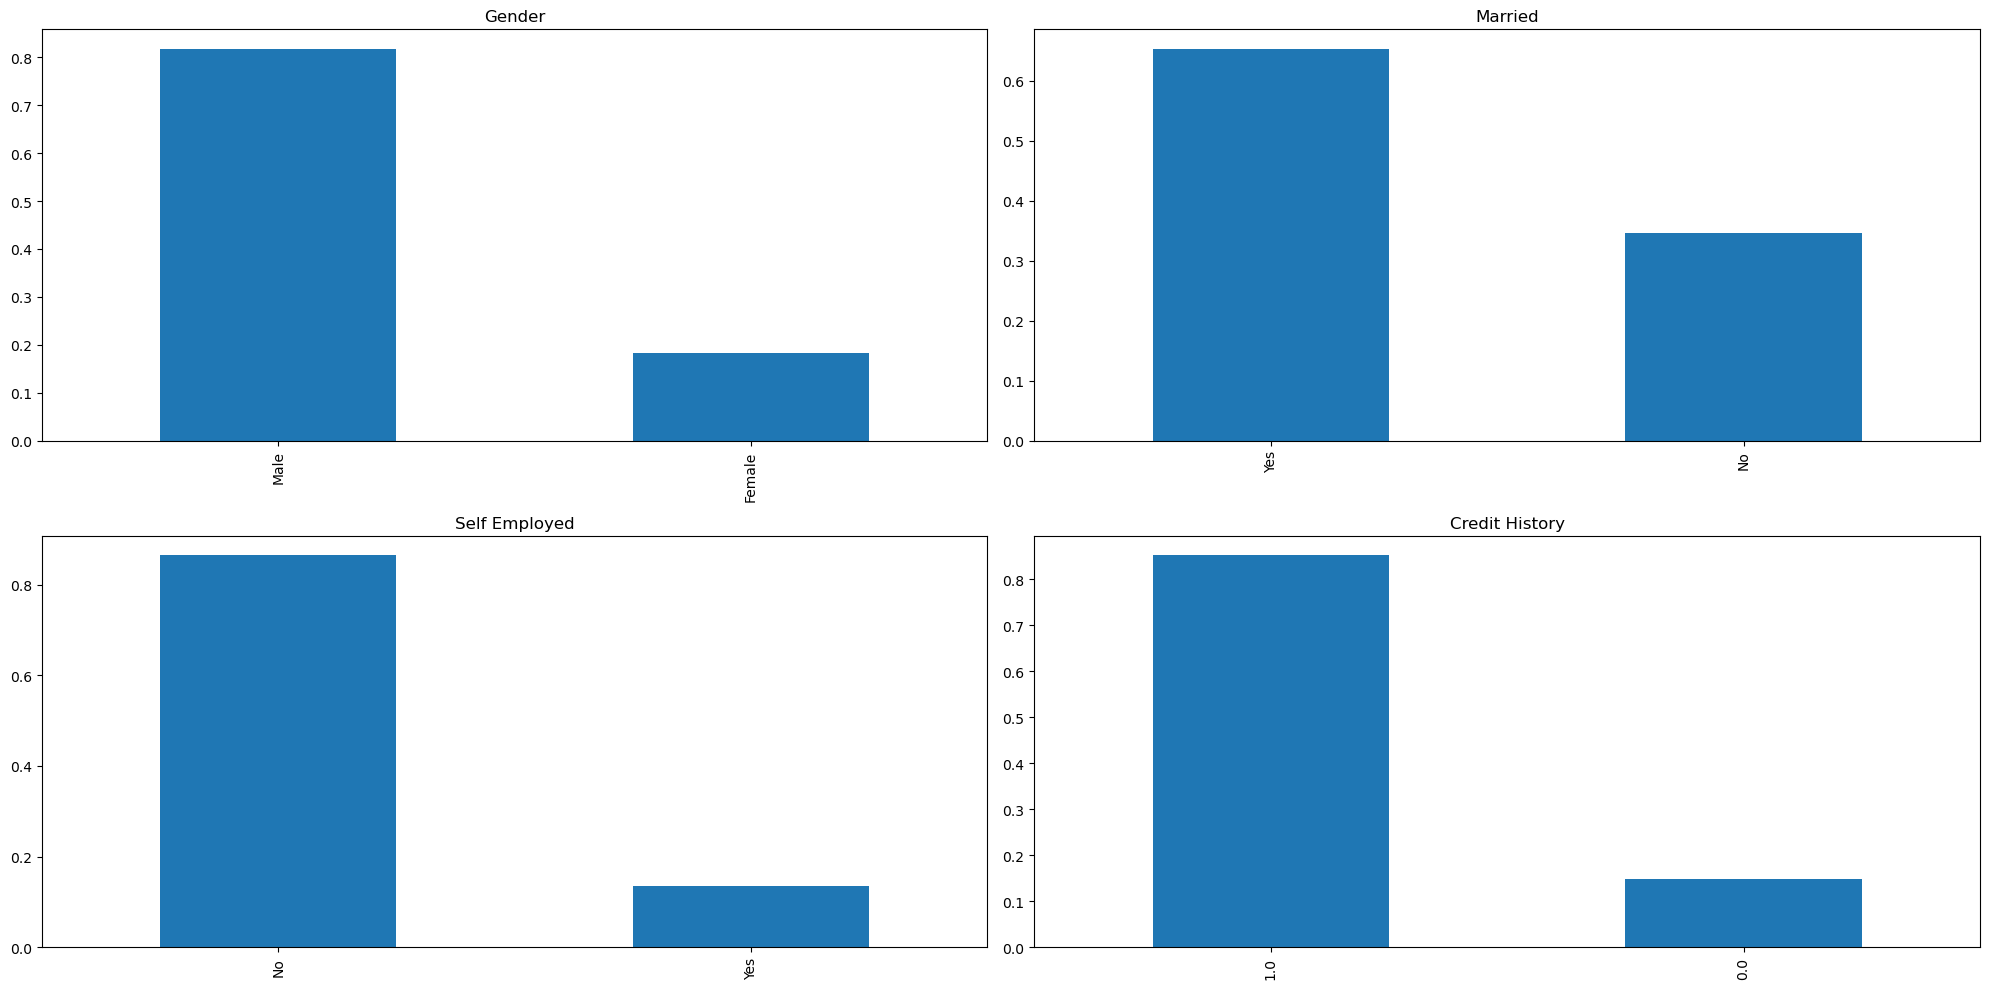

In [20]:
plt.figure()
plt.subplot(221)
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Gender')
plt.subplot(222)
train['Married'].value_counts(normalize=True).plot.bar(figsize=(20,10), title = 'Married')
plt.subplot(223)
train['Self_Employed'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Self Employed')
plt.subplot(224)
train['Credit_History'].value_counts(normalize=True).plot.bar(figsize=(20,10), title='Credit History')

plt.tight_layout()


- 80% of the applicants are male.
- Around 65% applicants are married.
- Around 15% applicant are self employed.
- Around 85% applicant have repaied their debts.

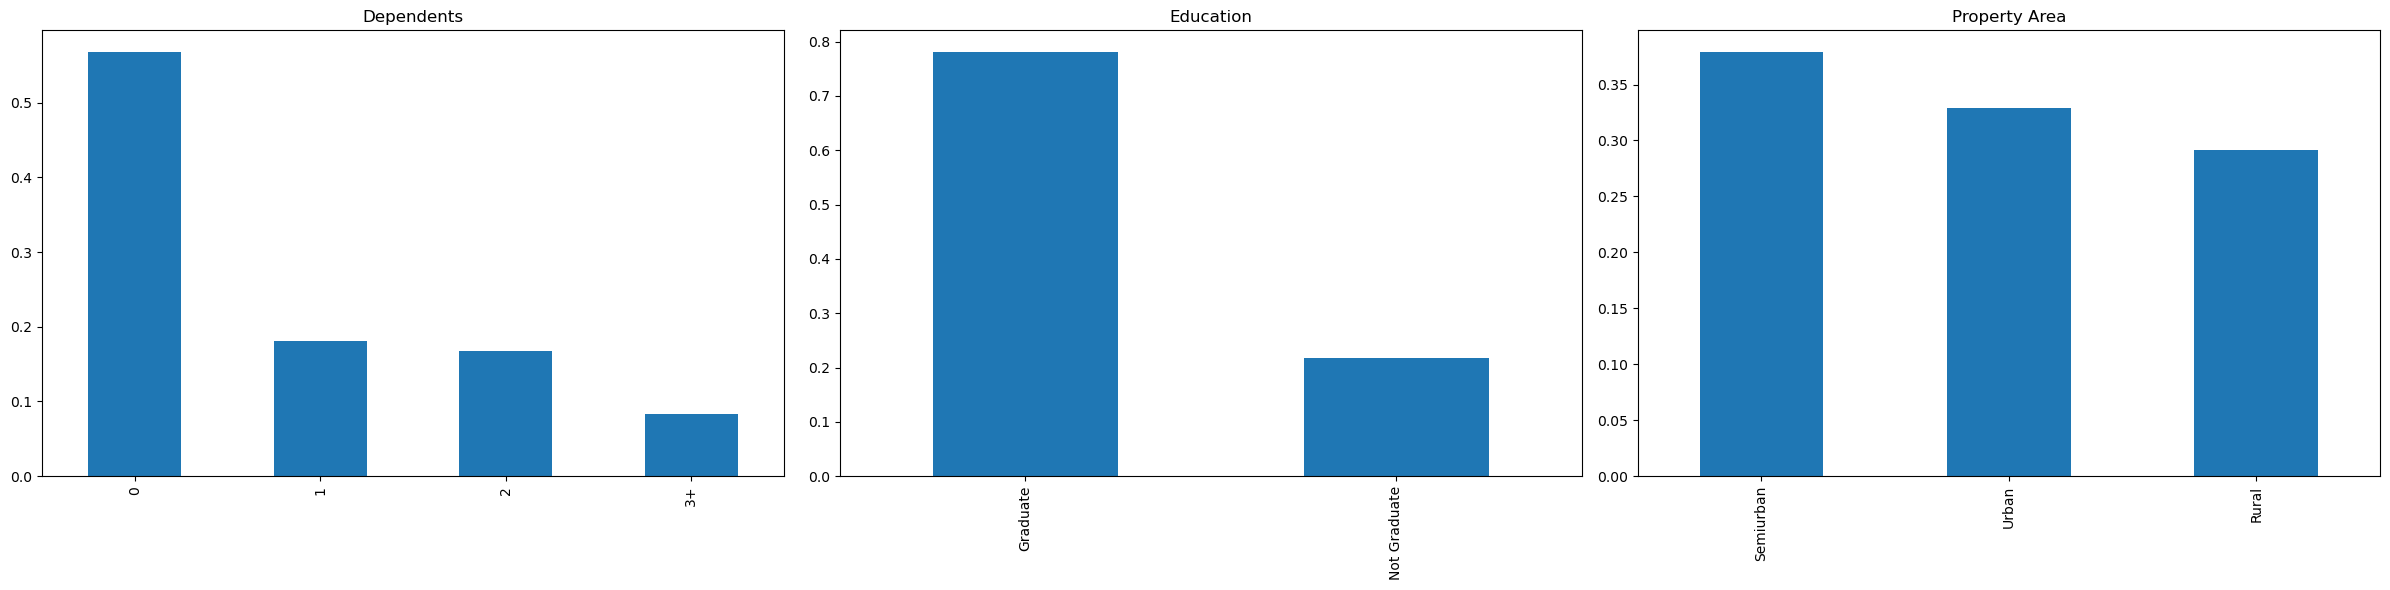

In [21]:
plt.figure()
plt.subplot(131)
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(24,6), title='Dependents')
plt.subplot(132)
train['Education'].value_counts(normalize=True).plot.bar(title='Education')
plt.subplot(133)
train['Property_Area'].value_counts(normalize=True).plot.bar(title='Property Area')
plt.tight_layout()

- Most of the applicants don't have dependents.
- Around 80% of the applicants are graduate.
- Most of the applicants are from Semiurban area.

### Distribution of Income variables

/var/folders/4c/8l6l08nj1gz4mkln9mdw_t_80000gn/T/ipykernel_44935/2568650623.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: >

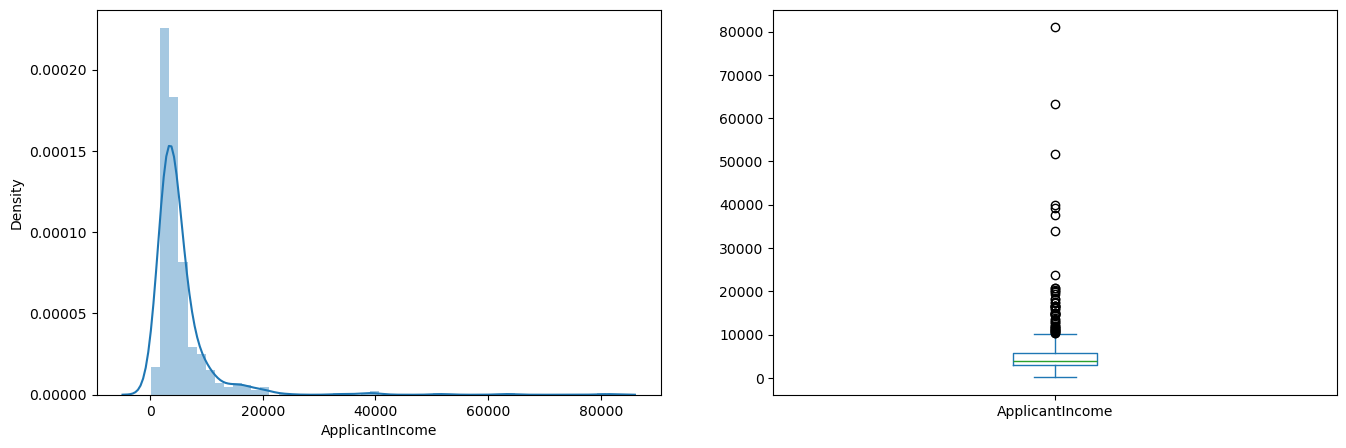

In [22]:
plt.figure()
plt.subplot(121)
sns.distplot(train['ApplicantIncome'])
plt.subplot(122)
train['ApplicantIncome'].plot.box(figsize=(16,5))

/var/folders/4c/8l6l08nj1gz4mkln9mdw_t_80000gn/T/ipykernel_44935/787503932.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: >

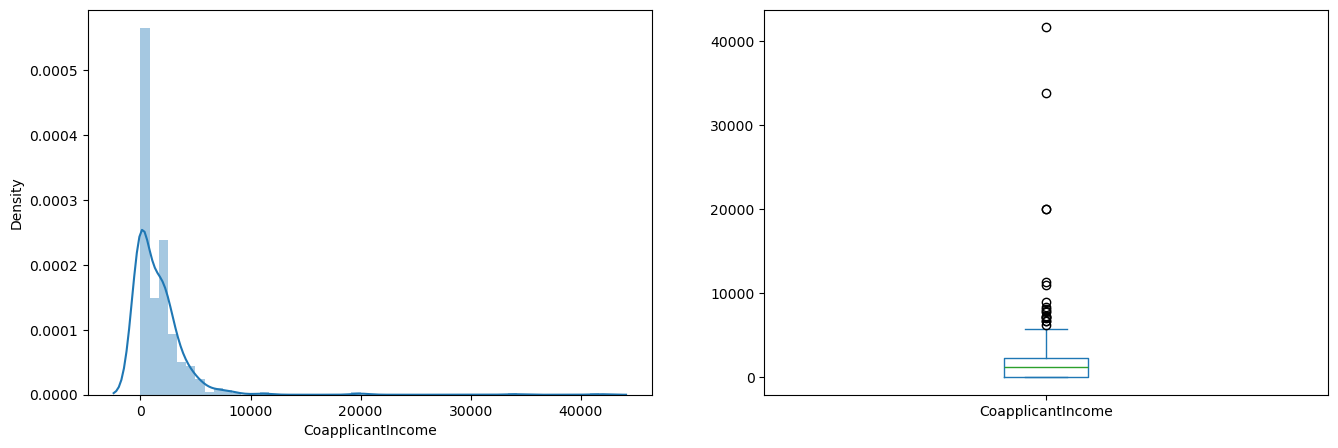

In [23]:
plt.figure()
plt.subplot(121)
sns.distplot(train['CoapplicantIncome'])
plt.subplot(122)
train['CoapplicantIncome'].plot.box(figsize=(16,5))

/var/folders/4c/8l6l08nj1gz4mkln9mdw_t_80000gn/T/ipykernel_44935/1550645400.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: >

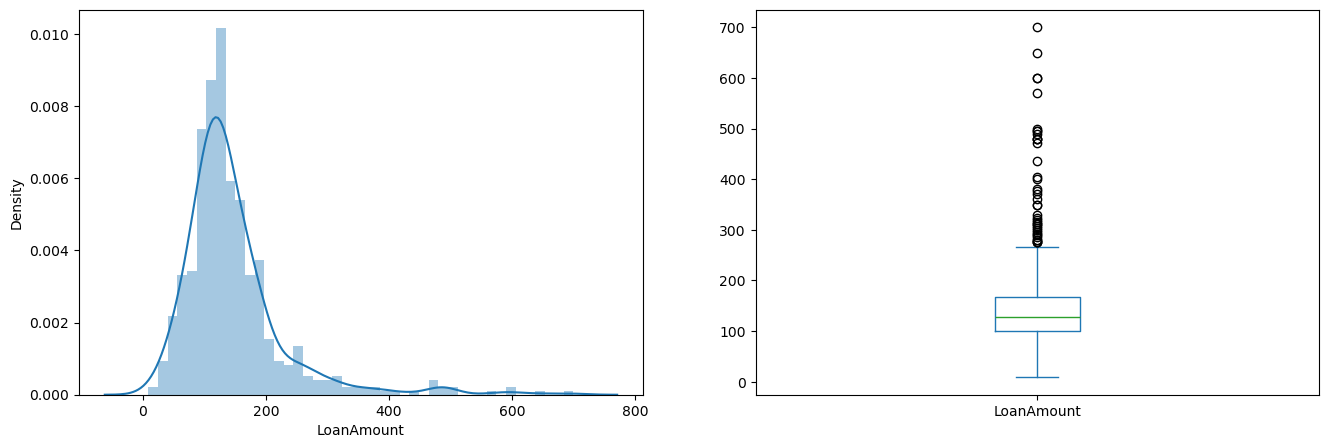

In [24]:
plt.figure()
plt.subplot(121)
sns.distplot(train['LoanAmount'])
plt.subplot(122)
train['LoanAmount'].plot.box(figsize=(16,5))

In [25]:
fig = px.scatter(train, x='ApplicantIncome', y='LoanAmount', color='Loan_Status', size='CoapplicantIncome',
                 hover_data=['Gender', 'Married', 'Education'],
                 title='Applicant Income vs Loan Amount')
fig.show()

### Loan Status by Category

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

categories = ['Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

fig = make_subplots(rows=1, cols=1)

dropdown_menu = []

for category in categories:
    counts = train.groupby([category, 'Loan_Status']).size().unstack(fill_value=0)

    trace = go.Bar(x=counts.index, y=counts['Y'], name='Approved', offsetgroup=0)
    trace2 = go.Bar(x=counts.index, y=counts['N'], name='Not Approved', offsetgroup=0)

    dropdown_menu.append({'method': 'update',
                          'label': category,
                          'args': [{'x': [counts.index, counts.index],
                                    'y': [counts['Y'], counts['N']]}]})

    fig.add_trace(trace)
    fig.add_trace(trace2)

fig.update_layout(
    updatemenus=[{
        'active': 0,
        'buttons': dropdown_menu,
        'x': 0.1,
        'y': 1.15,
        'xanchor': 'left',
        'yanchor': 'top',
    }],
    barmode='stack',
    height=600,
    width=800,
    title={
        'text': "Loan Status by Category",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Category",
    yaxis_title="Count of Records",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(t=120)
)

for i in range(2, len(fig.data)):
    fig.data[i].visible = False

fig.show()

### Correlation between numerical variables

In [27]:
train['Dependents'].replace('3+', 3, inplace=True)
predict['Dependents'].replace('3+', 3, inplace=True)
train['Loan_Status'].replace('N', 0, inplace=True)
train['Loan_Status'].replace('Y', 1, inplace=True)

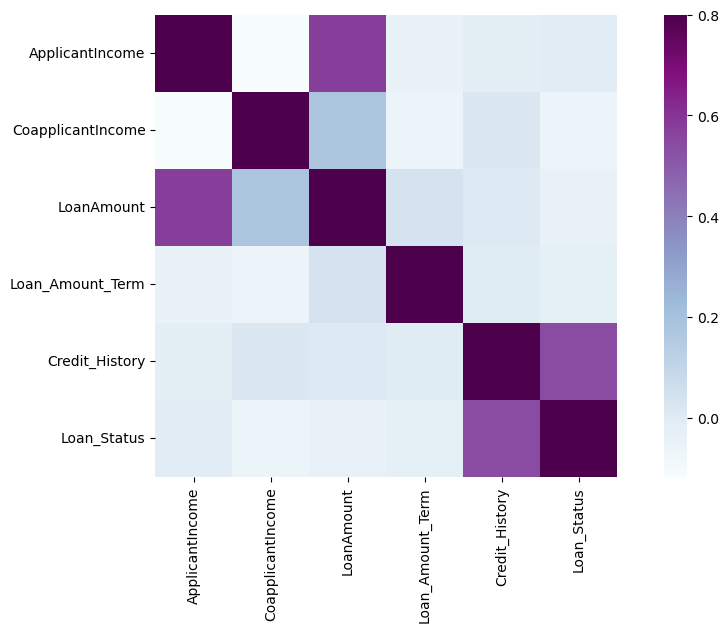

In [28]:
numeric_cols = train.select_dtypes(include=['int64', 'float64'])

corr = numeric_cols.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr, vmax=0.8, square=True, cmap='BuPu')
plt.show()


# Model Building

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

### Feature Engineering

In [30]:
# Feature Engineering
x = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']
x['Income_Loan_Ratio'] = x['ApplicantIncome'] / (x['LoanAmount'] + 1)
x['Total_Income'] = x['ApplicantIncome'] + x['CoapplicantIncome']
x['Log_Total_Income'] = np.log1p(x['Total_Income'])

# Convert object into string
for col in x.select_dtypes(include=['object']).columns:
    x[col] = x[col].astype(str)


In [32]:
# Seperate numerical features and categorical features
numeric_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x.select_dtypes(include=['object']).columns

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# fit and transform data
x_encoded = preprocessor.fit_transform(x)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Create new DataFrame
x_encoded = pd.DataFrame(x_encoded, columns=feature_names, index=x.index)


In [33]:
# Select feature
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(x_encoded, y)
x_selected = selector.transform(x_encoded)

selected_features = x_encoded.columns[selector.get_support()]

# Create new DataFrame
x_selected = pd.DataFrame(x_selected, columns=selected_features, index=x.index)


### Split the dataset

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x_selected, y, test_size=0.2, random_state=42)

# SMOTE for imbalance
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Standardization
scaler = StandardScaler()
x_train_resampled = scaler.fit_transform(x_train_resampled)
x_test = scaler.transform(x_test)

### Logistic Regression

In [36]:
# Logistic Regression with Bagging
lg = BaggingClassifier(estimator=LogisticRegression(), random_state=42)
lg_params = {
    'estimator__C': [0.1, 0.15, 0.2, 0.5],
    'n_estimators': [10, 12, 15, 20, 25],
    'max_samples': [0.5, 0.8, 1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(lg, lg_params, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_lg = grid_search.best_estimator_

print(f'Best parameters for Logistic Regression (Bagging): {grid_search.best_params_}')
print(f'Best cross-validation accuracy for Logistic Regression (Bagging): {grid_search.best_score_:.4f}')


Best parameters for Logistic Regression (Bagging): {'bootstrap': True, 'estimator__C': 0.15, 'max_samples': 0.8, 'n_estimators': 15}
Best cross-validation accuracy for Logistic Regression (Bagging): 0.8085


### Decision Tree

In [37]:
# Decision Tree with Bagging
dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)
dt_params = {
    'estimator__max_depth': [None, 5, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10, 15, 20],
    'n_estimators': [20, 25, 30, 40, 50],
    'max_samples': [0.1, 0.2, 0.3, 0.5, 0.8],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_dt = grid_search.best_estimator_

print(f'Best parameters for Decision Tree (Bagging): {grid_search.best_params_}')
print(f'Best cross-validation accuracy for Decision Tree (Bagging): {grid_search.best_score_:.4f}')


Best parameters for Decision Tree (Bagging): {'bootstrap': False, 'estimator__max_depth': 10, 'estimator__min_samples_split': 10, 'max_samples': 0.3, 'n_estimators': 40}
Best cross-validation accuracy for Decision Tree (Bagging): 0.8247


### Random Forest

In [42]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [300, 500, 800, 1000],
    'max_depth': [10, 12, 15, 20, 50],
    'min_samples_split': [15, 20, 25, 30, 40],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
grid_search_rf.fit(x_train, y_train)

best_rf = grid_search_rf.best_estimator_

print(f'Best parameters for Random Forest: {grid_search_rf.best_params_}')
print(f'Best cross-validation accuracy for Random Forest: {grid_search_rf.best_score_:.4f}')


Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 800}
Best cross-validation accuracy for Random Forest: 0.8147


### XGBoost

In [39]:
# XGBoost
xgb = XGBClassifier(random_state=42)
xgb_params = {
    'n_estimators': [400, 420, 450, 470, 500],
    'learning_rate': [0.0005, 0.0008, 0.001],
    'max_depth': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy')
grid_search_xgb.fit(x_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

print(f'Best parameters for XGBoost: {grid_search_xgb.best_params_}')
print(f'Best cross-validation accuracy for XGBoost: {grid_search_xgb.best_score_:.4f}')

Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 450, 'subsample': 0.8}
Best cross-validation accuracy for XGBoost: 0.8146


### Feature Importance

In [40]:

if hasattr(best_rf, 'feature_importances_'):
    importances = best_rf.feature_importances_
    feature_names = selector.get_feature_names_out()
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("\nRandom Forest Feature Importance:")
    print(feature_importance)

if hasattr(best_xgb, 'feature_importances_'):
    importances = best_xgb.feature_importances_
    feature_names = selector.get_feature_names_out()
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("\nXGBoost Feature Importance:")
    print(feature_importance)


Random Forest Feature Importance:
                  feature  importance
3     num__Credit_History    0.445891
6   num__Log_Total_Income    0.108071
5       num__Total_Income    0.108034
4  num__Income_Loan_Ratio    0.097319
0    num__ApplicantIncome    0.090368
2         num__LoanAmount    0.089706
1  num__CoapplicantIncome    0.060611

XGBoost Feature Importance:
                  feature  importance
3     num__Credit_History         1.0
0    num__ApplicantIncome         0.0
1  num__CoapplicantIncome         0.0
2         num__LoanAmount         0.0
4  num__Income_Loan_Ratio         0.0
5       num__Total_Income         0.0
6   num__Log_Total_Income         0.0
